In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.utils.data as data_utils
from torch.autograd import Variable
import torchvision.datasets as dsets
import math
import torchvision.models as models
from PIL import Image
from deepfool import deepfool
import os,sys
from FGSM import fgsm,fgsm_graybox
from train_mnist_model import Net
from tqdm import tqdm
from torch.distributions.categorical import Categorical

homedir = '/home/nikhil/research/Examining-Robustness-of-BNNs-to-Adversarial-Examples/'
# homedir = '/home/serge/Documents/Classes/Adversarial_ML/Examining-Robustness-of-BNNs-to-Adversarial-Examples/'
MODULE_PATH = ['{}BNN_Implementations/PyTorch-BayesianCNN-master'.format(homedir),
          '{}BNN_Implementations/PyTorch-BayesianCNN-master/models/BayesianModels'.format(homedir)]

for m in MODULE_PATH:
    sys.path.append(m)

import data
from BayesianLeNet import BBBLeNet
import metrics
from utils import *
# from models.NonBayesianModels.LeNet import LeNet

In [2]:
def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        #nn.init.xavier_uniform(m.weight, gain=np.sqrt(2))
        nn.init.normal_(m.weight, mean=0, std=1)
        nn.init.constant(m.bias, 0)

class LeNet(nn.Module):
    def __init__(self, num_classes, inputs=3):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(inputs, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, num_classes)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)

        return(out)

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [4]:
dataset = 'MNIST'
batch_size=1000
valid_size = 0.2 # will not be used 
num_workers = 0

trainset, testset, inputs, outputs = data.getDataset(dataset)
train_loader, valid_loader, test_loader = data.getDataloader(trainset, testset, valid_size, 
                                                             batch_size, num_workers)


In [5]:
def bayes_marginalization(net, inputs, J=10):
    
    outputs = torch.zeros(inputs.shape[0], net.num_classes, J).to(device)
    kl = 0.0

    for j in range(J):
        net_out, _kl = net(inputs)
        kl += _kl
        outputs[:, :, j] = F.log_softmax(net_out, dim=1).data
    
    log_outputs = logmeanexp(outputs, dim=2)
    return log_outputs, kl

def bayes_evaluation(net, criterion, validloader, num_ens=100):
    """Calculate ensemble accuracy and NLL Loss"""

    net.train(True)
    
    valid_loss = 0.0
    accs = []

    for i, (inputs, labels) in enumerate(validloader):
        inputs, labels = inputs.to(device), labels.to(device)
                
        log_outputs, kl = bayes_marginalization(net, inputs, num_ens)
        valid_loss += criterion(log_outputs, labels, kl).item()
        accs.append(metrics.acc(log_outputs, labels))

    return valid_loss/len(validloader), np.mean(accs)

def frequentist_evaluation(net, criterion, valid_loader):
    
    valid_loss = 0.0
    accs = []
    net.eval()
    for data, target in valid_loader:
        data, target = data.to(device), target.to(device)
        output = net(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        accs.append(metrics.acc(output.data, target))

    return valid_loss, accs

In [6]:
def attack_fgsm(model,loss,eps,device,loader,is_bayes=False):
    original_preds_soft = []
    attack_preds_soft = []
    
    for batch_idx, (images, labels) in enumerate(loader):
        
        attack_images = fgsm(model=model,loss=loss,device=device,images=images,labels=labels,eps=eps,is_bayes=is_bayes)
        
        if is_bayes:
            original_preds_soft.append(model(images.to(device))[0].detach())
            attack_preds_soft.append(model(attack_images)[0].detach())
        else:
            original_preds_soft.append(model(images.to(device)).detach())
            attack_preds_soft.append(model(attack_images).detach())
        
    original_preds_soft = torch.cat(original_preds_soft, dim=0)
    attack_preds_soft = torch.cat(attack_preds_soft,dim=0)
    original_preds = torch.argmax(original_preds_soft,axis=1)
    attack_preds = torch.argmax(attack_preds_soft,axis=1)
    
    success_rate = torch.mean((original_preds!=attack_preds).type(torch.DoubleTensor)).cpu().detach().numpy()
    entropy = np.mean(Categorical(probs = F.softmax(attack_preds_soft,dim=0)).entropy().cpu().detach().numpy())
    
    return success_rate,entropy

In [7]:
def attack_fgsm_v2 (model,loss,eps,device,loader,is_bayes=False):
    
    attack_preds_soft = []
    attack_acc = []
    
    for batch_idx, (images, labels) in enumerate(loader):
        
        attack_images = fgsm(model=model,loss=loss,device=device,images=images,labels=labels,eps=eps,is_bayes=is_bayes)
        
        if is_bayes:
            log_outputs, _ = bayes_marginalization(model, attack_images, J=100)
            attack_preds_soft.append(log_outputs)
            attack_acc.append(metrics.acc(log_outputs, labels))
        else:
            outputs = model(attack_images).detach()
            attack_preds_soft.append(outputs)
            attack_acc.append(metrics.acc(outputs, labels))

    attack_preds_soft = torch.cat(attack_preds_soft,dim=0)
    attack_preds = torch.argmax(attack_preds_soft,axis=1)

    if is_bayes:
        entropy = np.mean(Categorical(probs = torch.exp(attack_preds_soft)).entropy().cpu().detach().numpy())
    else:
        entropy = np.mean(Categorical(probs = F.softmax(attack_preds_soft,dim=0)).entropy().cpu().detach().numpy())
    
    return np.mean(attack_acc), entropy


# Example attack on a non-Bayes CNN (MNIST)

In [8]:
model = LeNet(num_classes=10,inputs=1)
ckpt_path = '../../BNN_Implementations/PyTorch-BayesianCNN-master/checkpoints/MNIST/frequentist/model_lenet.pt'
model.load_state_dict(torch.load(ckpt_path))
model.eval()
device = torch.device('cuda:0')
model.to(device)
loss = nn.CrossEntropyLoss()

In [9]:
original_loss, original_acc = frequentist_evaluation(model, loss, test_loader)

In [10]:
print (np.mean(original_acc))

0.9776999999999999


In [12]:
epsilons = np.linspace(0,0.5,20)
acc = []
entropies = []
for eps in tqdm(epsilons):
    success_rate,entropy = attack_fgsm_v2(model,loss,eps,device,test_loader)
    acc.append(success_rate)
    entropies.append(entropy)

100%|██████████| 20/20 [00:34<00:00,  1.70s/it]


Text(0, 0.5, 'Average predictive entropy')

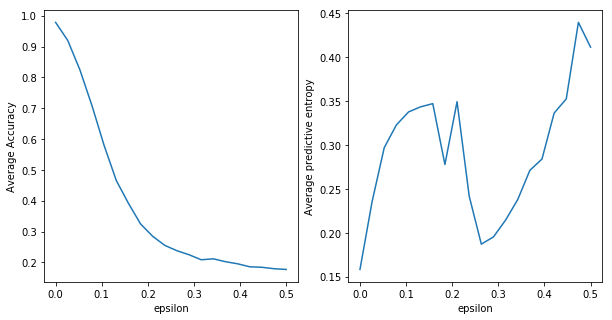

In [14]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epsilons,acc)
plt.xlabel('epsilon')
plt.ylabel('Average Accuracy')
plt.subplot(1,2,2)
plt.plot(epsilons,entropies)
plt.xlabel('epsilon')
plt.ylabel('Average predictive entropy')

# Example attack on BayesNet

In [15]:
model = BBBLeNet(outputs=10,inputs=1)
ckpt_path = 'BNN_Implementations/PyTorch-BayesianCNN-master/checkpoints/MNIST/bayesian'
ckpt_name = 'model_lenet.pt'
model.load_state_dict(torch.load(os.path.join(homedir,ckpt_path,ckpt_name)))
device = torch.device('cuda:0')
model.to(device)
loss = metrics.ELBO(len(test_loader.dataset)).to(device)

In [16]:
# model.train(True) => for sampling
model.training

True

In [17]:
original_loss, original_acc =  bayes_evaluation(model, loss, test_loader)

/media/bigguy/nm208/torch3/lib/python3.5/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [18]:
print (np.mean(original_acc))

0.9564


In [19]:
epsilons = np.linspace(0,0.5,20)
acc_bayes = []
entropies_bayes = []
for eps in tqdm(epsilons):
    success_rate,entropy = attack_fgsm_v2(model,loss,eps,device,test_loader,is_bayes=True)
    acc_bayes.append(success_rate)
    entropies_bayes.append(entropy)

100%|██████████| 20/20 [01:28<00:00,  4.43s/it]


Text(0, 0.5, 'Average predictive entropy')

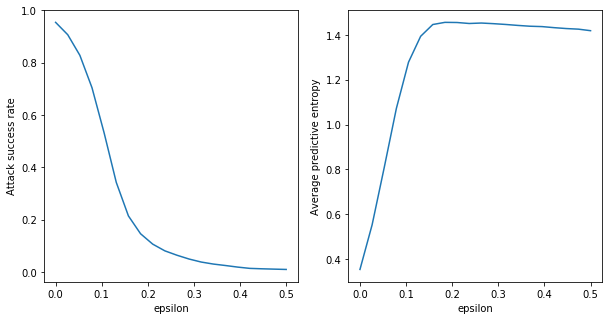

In [20]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epsilons,acc_bayes)
plt.xlabel('epsilon')
plt.ylabel('Attack success rate')
plt.subplot(1,2,2)
plt.plot(epsilons,entropies_bayes)
plt.xlabel('epsilon')
plt.ylabel('Average predictive entropy')

# Compare Bayes vs. non-Bayes

Text(0, 0.5, 'Average predictive entropy')

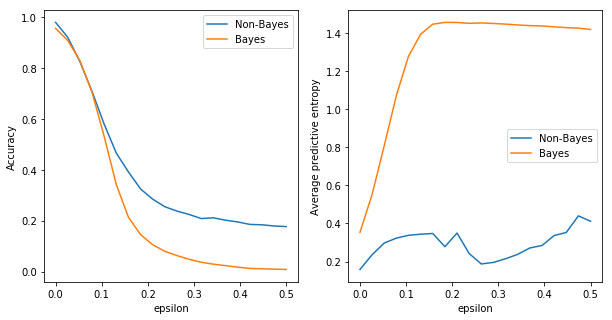

In [21]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epsilons,acc)
plt.plot(epsilons,acc_bayes)
plt.legend(['Non-Bayes','Bayes'])
plt.xlabel('epsilon')
plt.ylabel('Accuracy')
plt.subplot(1,2,2)
plt.plot(epsilons,entropies)
plt.plot(epsilons,entropies_bayes)
plt.legend(['Non-Bayes','Bayes'])
plt.xlabel('epsilon')
plt.ylabel('Average predictive entropy')